In [1]:
include("../HenryLib.jl")
Nspin=10
sb, Sx, Sy, Sz, idOp = make_operators(Nspin)
dts = (2//1) .^(-6:-2)#(-12:-2)
psi_ts = Vector{Vector{typeof(semiclassical.State(spindown(sb), ComplexF64[0.0]))}}(undef, 0)
err_ts = Vector{Vector{Float64}}(undef, 0)
sol_times = Vector{Float64}(undef, 0)
tout_course = nothing
seed=1729

CurrW = nothing
prob, full_cb, tspan, out, CurrW = dicke_hetrodyne_atom_only_prob(;Nspin=Nspin, κ=2π * 0.15, Δc=2π * 20, ωz=2π * 0.01, λ0=3.0, t_ramp=200.0, λmod=0.0, ωmod=2π * 1e-6 * 500.0, tmax=20000.0, recordtimes=2000, noise=CurrW, save_noise=true)
for dt in dts
    prob = remake(prob; noise=CurrW)
    sol_time = @elapsed sol1 = solve(prob, RKMilGeneral(;ii_approx=IICommutative());
                adaptive=false,
                dt=dt,
                save_everystep=false,
                save_start=false,
                save_end=false,
                saveat=tspan,
                callback=full_cb, seed=seed)

    CurrW = StochasticDiffEq.NoiseWrapper(CurrW)

    curr_psi_t = copy(out.saveval)
    push!(psi_ts, curr_psi_t)
    tout_course = copy(out.t)
    curr_psi_t_q = map(x->x.quantum, curr_psi_t); base_psi_t_q = map(x->x.quantum, psi_ts[begin]);
    curr_diff_t = curr_psi_t_q - base_psi_t_q
    curr_err_t = map(x->sqrt(real(dagger(x)*x)), curr_diff_t)
    push!(err_ts, curr_err_t)
    push!(sol_times, sol_time)
end

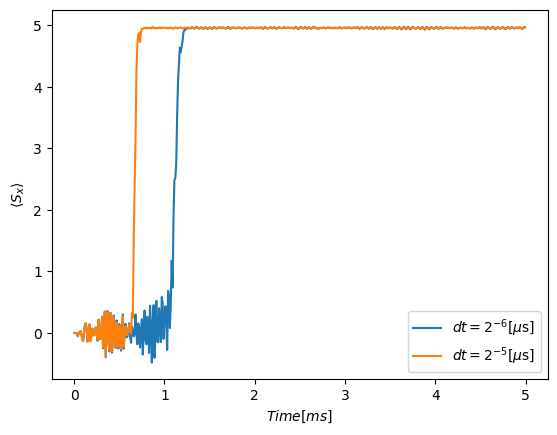

In [7]:
using PyPlot
for i in eachindex(psi_ts[1:2])
    plot(tout_course[begin:500]/1000.0, expect(Sx, psi_ts[i])[begin:500], label="\$dt=2^{$(Int(log(2, dts[i])))}\$[\$\\mu\$s]")
end
ylabel(L"$\langle S_x \rangle$")
xlabel(L"Time [ms]")
legend()
PyPlot.display_figs()

In [ ]:
for i in eachindex(psi_ts[begin:end])
    plot(tout_course, expect(idOp, psi_ts[i]), label="\$dt=2^{$(Int(log(2, dts[i])))}\$[\$\\mu\$s]")
end
ylabel(L"$\langle 1 \rangle$")
xlabel(L"Time [$\mu$s]")
# legend()
PyPlot.display_figs() 

In [ ]:
for i in eachindex(psi_ts[begin:end])
    plot(tout_course, expect(idOp, psi_ts_2[i]), label="\$dt=2^{$(Int(log(2, dts[i])))}\$[\$\\mu\$s]")
end
ylabel(L"$\langle 1 \rangle$")
xlabel(L"Time [$\mu$s]")
# legend()
PyPlot.display_figs()

In [ ]:
include("PlotingLib.jl")
x = expect(Sx, psi_ts[1])
y = expect(Sy, psi_ts[1])
z = expect(Sz, psi_ts[1])
blochplot3D(x,y,z)
PyPlot.display_figs()

In [37]:
include("../HenryLib.jl")
Nspin=100000
dts = (2//1) .^(-6:-2)
vec_ts = Vector{Vector{Vector{ComplexF64}}}(undef, 0)
err_ts = Vector{Vector{Float64}}(undef, 0)
sol_times_mean = Vector{Float64}(undef, 0)
sol_times_var = Vector{Float64}(undef, 0)
tout_course = nothing
seed=1729
samples = 100

CurrW = nothing
prob, full_cb, tspan, out, CurrW = dicke_hetrodyne_atom_only_meanfield_prob(;Nspin=Nspin, κ=2π * 0.15, Δc=-2π * 20, ωz=2π * 0.01, λ0=sqrt(5), t_ramp=600.0, t_hold=100.0, λmod=0.0, ωmod=2π * 1e-6 * 500.0, tmax=700.0, recordtimes=700, noise=CurrW, save_noise=true)
for dt in dts
    prob = remake(prob; noise=CurrW)

    sol_time_samples = zeros(samples)
    for i in 1:samples
        sol_time_samples[i] = @elapsed sol1 = solve(prob, RKMilGeneral(;ii_approx=IICommutative());
                    adaptive=false,
                    dt=dt,
                    save_everystep=false,
                    save_start=false,
                    save_end=false,
                    saveat=tspan,
                    callback=full_cb, seed=seed)
    end

    CurrW = StochasticDiffEq.NoiseWrapper(sol1.W)

    curr_vec_t = copy(out.saveval)
    push!(vec_ts, curr_vec_t)
    tout_course = copy(out.t)
    curr_err_t = map(x->sqrt(sum(conj.(x).*x)), curr_vec_t - vec_ts[begin])
    push!(err_ts, curr_err_t)
    push!(sol_times_mean, sol_time_samples |> mean)
    push!(sol_times_var, sol_time_samples |> var)
end

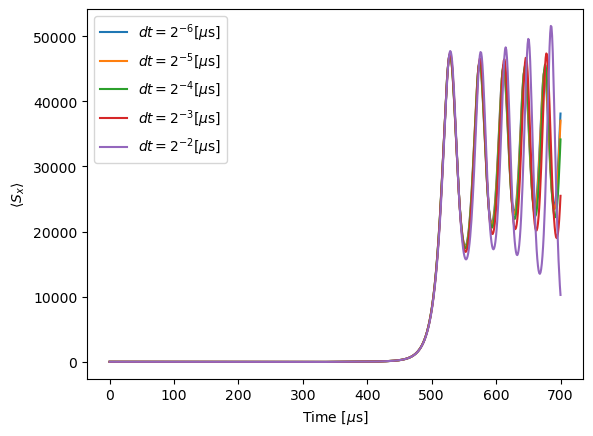

In [39]:
using PyPlot
for i in eachindex(vec_ts[begin:end])
    plot(tout_course, map(x->real(x[1]), vec_ts[i]), label="\$dt=2^{$(Int(log(2, dts[i])))}\$[\$\\mu\$s]")
end
ylabel(L"$\langle S_x \rangle$")
xlabel(L"Time [$\mu$s]")
legend()
PyPlot.display_figs()

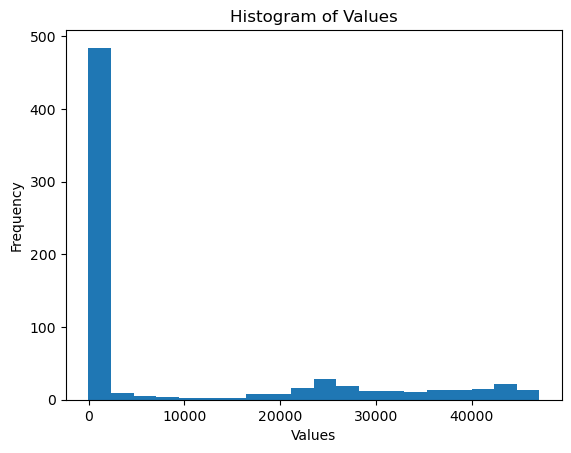

In [40]:
using PyPlot

values = map(x->real(x[1]), vec_ts[1])
hist(values, bins=20)
xlabel("Values")
ylabel("Frequency")
title("Histogram of Values")
PyPlot.display_figs()

In [41]:
using Distributions
# values = rand(Normal(1.0, 3.0), 10000)
N = length(values)
hatval = values .- mean(values)
thirdcum = sum(hatval .^3)/(N*(N-1)*(N-2))

8.749461931831276e6

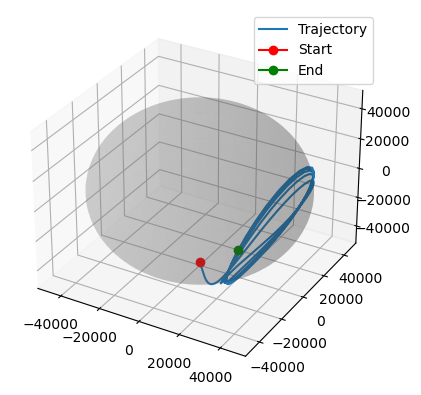

In [42]:
using PyPlot, LinearAlgebra
include("PlotingLib.jl")
i = 1
blochplot3D(map(x->real(x[1]), vec_ts[i]), map(x->real(x[2]), vec_ts[i]), map(x->real(x[3]), vec_ts[i]), Nspin=Nspin)
legend()
PyPlot.display_figs()

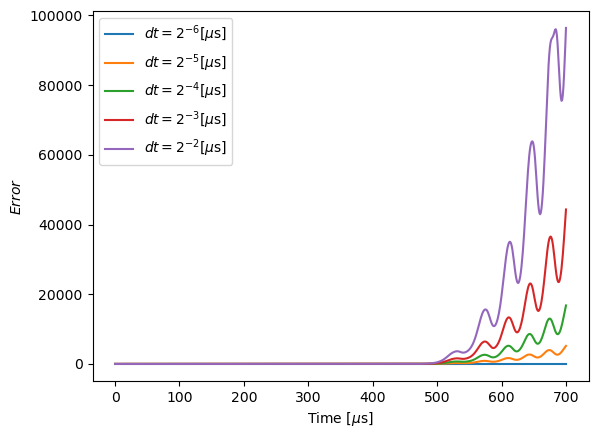

In [43]:
for i in eachindex(vec_ts[begin:end])
    plot(tout_course, err_ts[i], label="\$dt=2^{$(Int(log(2, dts[i])))}\$[\$\\mu\$s]")
end
ylabel(L"Error")
xlabel(L"Time [$\mu$s]")
legend()
PyPlot.display_figs()

In [44]:
sol_times_mean

5-element Vector{Float64}:
 0.079588075
 0.286324179
 0.628775643
 0.891868953
 0.970053698

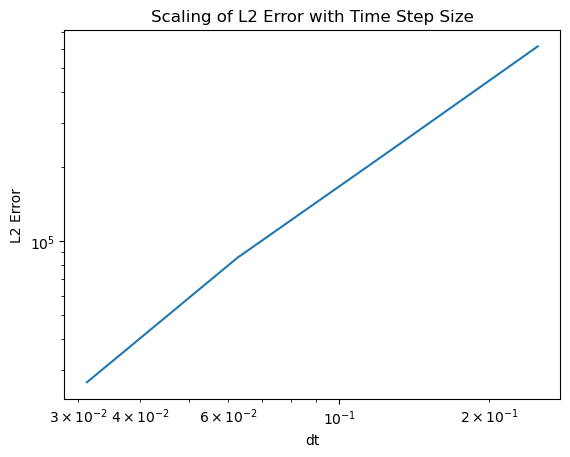

In [45]:
l2_errs = Vector{Float64}(undef, 0)
for i in eachindex(vec_ts[begin:end])
    push!(l2_errs, sqrt(sum(err_ts[i] .^2)))
end
PyPlot.loglog(dts[begin+1:end], l2_errs[begin+1:end])
ylabel("L2 Error")
xlabel("dt")
title("Scaling of L2 Error with Time Step Size")
PyPlot.display_figs()

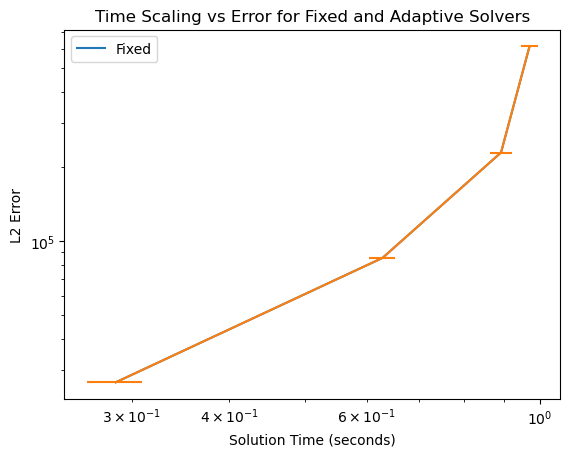

In [46]:
PyPlot.loglog(sol_times_mean[begin+1:end], l2_errs[begin+1:end], label="Fixed")
PyPlot.errorbar(sol_times_mean[begin+1:end], l2_errs[begin+1:end], xerr=sqrt.(sol_times_var[begin+1:end]/samples)/sol_times_mean[begin+1:end])
xlabel("Solution Time (seconds)")
ylabel("L2 Error")
legend()
title("Time Scaling vs Error for Fixed and Adaptive Solvers")
PyPlot.display_figs()

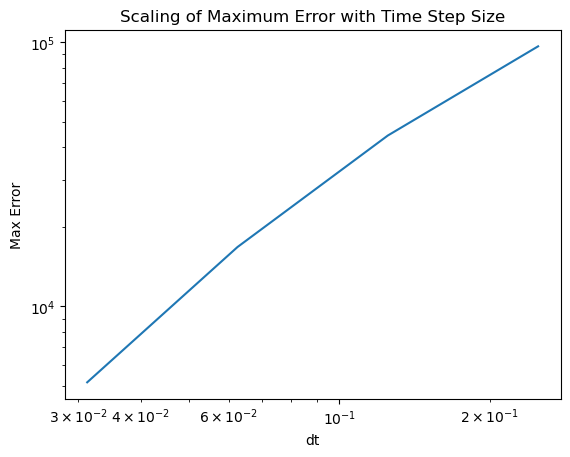

In [20]:
max_errs = Vector{Float64}(undef, 0)
for i in eachindex(vec_ts[begin:end])
    push!(max_errs, max(err_ts[i]...))
end
PyPlot.loglog(dts[begin+1:end], max_errs[begin+1:end])
ylabel("Max Error")
xlabel("dt")
title("Scaling of Maximum Error with Time Step Size")
PyPlot.display_figs()

In [61]:
include("../HenryLib.jl")
reltols = (10//1) .^(-8:-3)
ad_vec_ts = Vector{Vector{Vector{ComplexF64}}}(undef, 0)
ad_err_ts = Vector{Vector{Float64}}(undef, 0)
ad_sol_times = Vector{Float64}(undef, 0)
ad_tout_course = nothing
tout_course = nothing
seed=1729
Nspin=100000

CurrW = nothing
prob, full_cb, tspan, out, CurrW = dicke_hetrodyne_atom_only_meanfield_prob(;Nspin=Nspin, κ=2π * 0.15, Δc=-2π * 20, ωz=2π * 0.01, λ0=sqrt(5), t_ramp=600.0, t_hold=100.0, λmod=0.0, ωmod=2π * 1e-6 * 500.0, tmax=700.0, recordtimes=700, noise=CurrW, save_noise=true)
for reltol in reltols
    prob = remake(prob; noise=CurrW)
    sol_time = @elapsed sol1 = solve(prob, RKMilCommute();
                adaptive=true,
                dt=1//2^(10),
                reltol = reltol,
                abstol = reltol,
                save_everystep=false,
                save_start=false,
                save_end=false,
                saveat=tspan,
                callback=full_cb, seed=seed, maxiters=Int(1e8))

    CurrW = StochasticDiffEq.NoiseWrapper(CurrW)
    curr_vec_t = copy(out.saveval)
    push!(ad_vec_ts, curr_vec_t)
    tout_course = copy(out.t)
    curr_err_t = map(x->sqrt(sum(conj.(x).*x)), curr_vec_t - ad_vec_ts[begin])
    push!(ad_err_ts, curr_err_t )
    push!(ad_sol_times, sol_time)
end

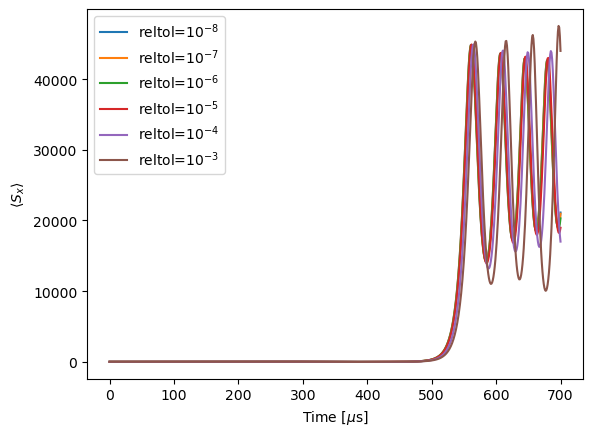

In [62]:
using PyPlot
for i in eachindex(ad_vec_ts[begin:end])
    plot(tout_course, map(x->real(x[1]), ad_vec_ts[i]), label="reltol=\$10^{$(Int(round(log(reltols[i])/log(10))))}\$")
end
ylabel(L"$\langle S_x \rangle$")
xlabel(L"Time [$\mu$s]")
legend()
PyPlot.display_figs()

In [29]:
using PyPlot, LinearAlgebra
include("PlotingLib.jl")
i = 1
blochplot3D(map(x->real(x[1]), ad_vec_ts[i]), map(x->real(x[2]), ad_vec_ts[i]), map(x->real(x[3]), ad_vec_ts[i]), Nspin=Nspin)
legend()
PyPlot.display_figs()

UndefVarError: UndefVarError: `ad_vec_ts` not defined

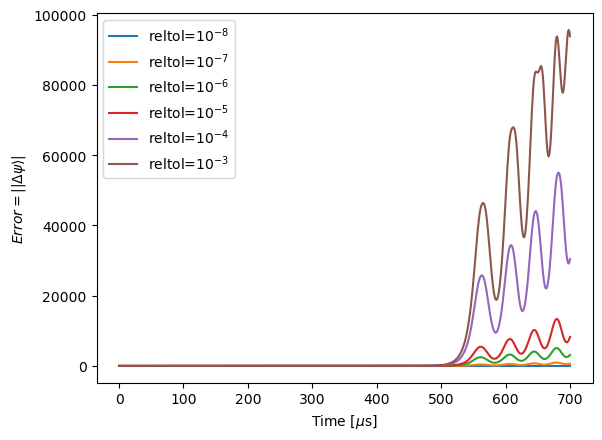

In [64]:
for i in eachindex(ad_vec_ts[begin:end])
    plot(tout_course, ad_err_ts[i], label="reltol=\$10^{$(Int(round(log(reltols[i])/log(10))))}\$")
end
ylabel(L"Error= || \Delta \psi \rangle |")
xlabel(L"Time [$\mu$s]")
legend()
PyPlot.display_figs()

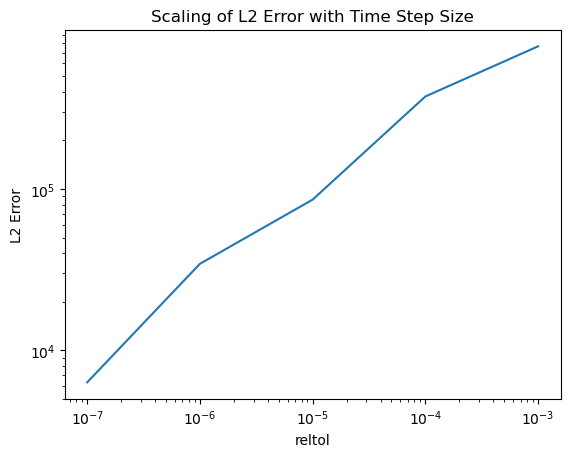

In [65]:
ad_l2_errs = Vector{Float64}(undef, 0)
for i in eachindex(ad_vec_ts[begin:end])
    push!(ad_l2_errs, sqrt(sum(ad_err_ts[i] .^2)))
end
PyPlot.loglog(reltols[begin+1:end], ad_l2_errs[begin+1:end])
ylabel("L2 Error")
xlabel("reltol")
title("Scaling of L2 Error with Time Step Size")
PyPlot.display_figs()

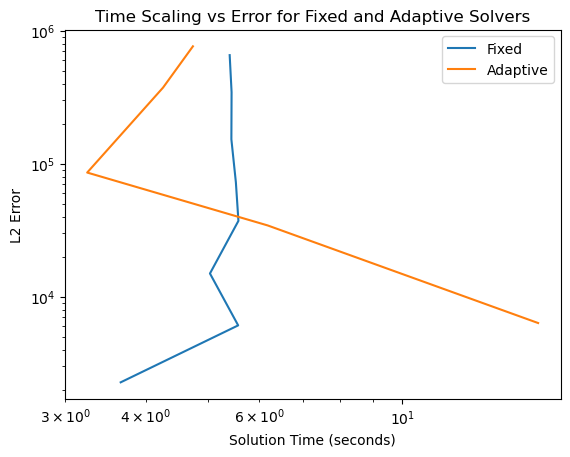

In [80]:
PyPlot.loglog(sol_times[begin+1:end], l2_errs[begin+1:end], label="Fixed")
PyPlot.loglog(ad_sol_times[begin+1:end], ad_l2_errs[begin+1:end], label="Adaptive")
xlabel("Solution Time (seconds)")
ylabel("L2 Error")
legend()
title("Time Scaling vs Error for Fixed and Adaptive Solvers")
PyPlot.display_figs()

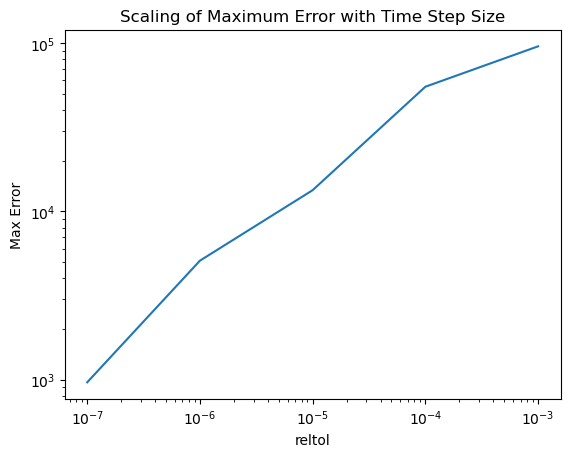

In [66]:
ad_max_errs = Vector{Float64}(undef, 0)
for i in eachindex(ad_vec_ts[begin:end])
    push!(ad_max_errs, max(ad_err_ts[i]...))
end
PyPlot.loglog(reltols[begin+1:end], ad_max_errs[begin+1:end])
ylabel("Max Error")
xlabel("reltol")
title("Scaling of Maximum Error with Time Step Size")
PyPlot.display_figs()

In [57]:
reltols = (10//1) .^(-8:-3)
ad_psi_ts = Vector{Vector{out_type}}(undef, 0)
ad_err_ts = Vector{Vector{Float64}}(undef, 0)
ad_sol_times = Vector{Float64}(undef, 0)
ad_tout_course = nothing


for reltol in reltols
    function norm_func(u, t, integrator) 
        semiclassical.recast!(stateG, u)
        normalize!(stateG)
        semiclassical.recast!(u, stateG)
    end
    ncb = DiffEqCallbacks.FunctionCallingCallback(norm_func;
                func_everystep=true,
                func_start=false)
    out = DiffEqCallbacks.SavedValues(eltype(tspan),out_type)
    scb = DiffEqCallbacks.SavingCallback(fout_,out,saveat=tspan,
                                            save_everystep=false,
                                            save_start = false,
                                            tdir = first(tspan)<last(tspan) ? one(eltype(tspan)) : -one(eltype(tspan)))
    full_cb = OrdinaryDiffEq.CallbackSet(nothing, ncb, scb)
    prob = SDEProblem(f!,g!, u0, (tspan[begin], tspan[end]); noise_rate_prototype=noise_prototype, noise=CurrW)
    sol_time = @elapsed sol1 = solve(prob, RKMilCommute();
                adaptive=true,
                dt=1//2^(10),
                reltol = reltol,
                abstol = reltol,
                save_everystep=false,
                save_start=false,
                save_end=false,
                saveat=tspan,
                callback=full_cb, seed=seed)

    CurrW = NoiseWrapper(CurrW)

    curr_psi_t = copy(out.saveval)
    push!(ad_psi_ts, curr_psi_t)
    tout_course = copy(out.t)
    curr_psi_t_q = map(x->x.quantum, curr_psi_t); base_psi_t_q = map(x->x.quantum, psi_ts[begin]);
    curr_diff_t = curr_psi_t_q - base_psi_t_q
    curr_err_t = map(x->sqrt(real(dagger(x)*x)), curr_diff_t)
    push!(ad_err_ts, curr_err_t)
    push!(ad_sol_times, sol_time)
end

UndefVarError: UndefVarError: `out_type` not defined

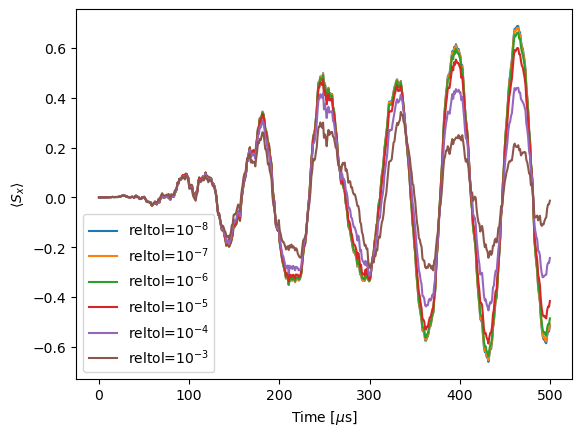

In [87]:
for i in eachindex(ad_psi_ts[begin:end])
    plot(tout_course, expect(Sx, ad_psi_ts[i]), label="reltol=\$10^{$(Int(round(log(reltols[i])/log(10))))}\$")
end
ylabel(L"$\langle S_x \rangle$")
xlabel(L"Time [$\mu$s]")
legend()
PyPlot.display_figs()

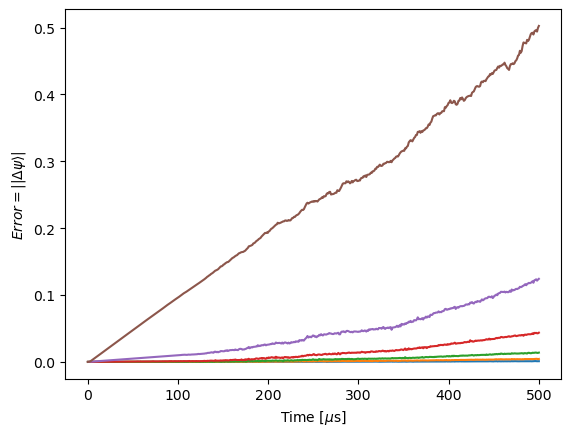

In [88]:
for i in eachindex(ad_psi_ts[begin:end])
    plot(tout_course, ad_err_ts[i], label="reltol=\$10^{$(Int(round(log(reltols[i])/log(10))))}\$")
end
ylabel(L"Error= || \Delta \psi \rangle |")
xlabel(L"Time [$\mu$s]")
# legend()
PyPlot.display_figs()

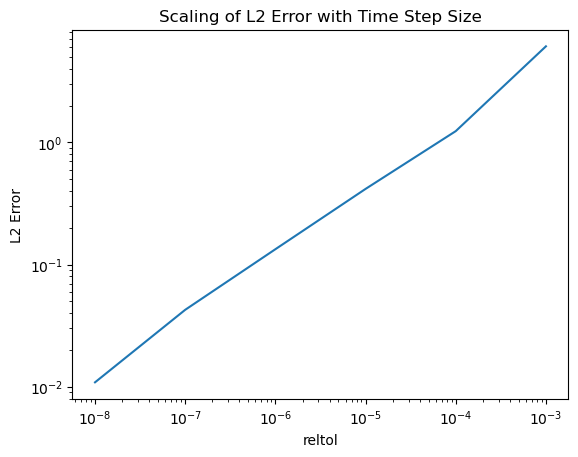

In [89]:
ad_l2_errs = Vector{Float64}(undef, 0)
for i in eachindex(ad_psi_ts[begin:end])
    push!(ad_l2_errs, sqrt(sum(ad_err_ts[i] .^2)))
end
PyPlot.loglog(reltols[begin:end], ad_l2_errs[begin:end])
ylabel("L2 Error")
xlabel("reltol")
title("Scaling of L2 Error with Time Step Size")
PyPlot.display_figs()

In [56]:
ad_max_errs = Vector{Float64}(undef, 0)
for i in eachindex(ad_psi_ts[begin:end])
    push!(ad_max_errs, max(ad_err_ts[i]...))
end
PyPlot.loglog(reltols[begin:end], ad_max_errs[begin:end])
ylabel("Max Error")
xlabel("reltol")
title("Scaling of Maximum Error with Time Step Size")
PyPlot.display_figs()

UndefVarError: UndefVarError: `ad_psi_ts` not defined

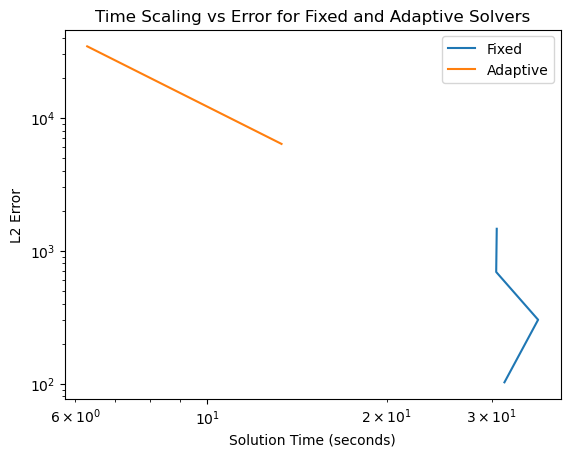

In [55]:
PyPlot.loglog(sol_times[begin+1:end], l2_errs[begin+1:end], label="Fixed")
PyPlot.loglog(ad_sol_times[begin+1:end], ad_l2_errs[begin+1:end], label="Adaptive")
xlabel("Solution Time (seconds)")
ylabel("L2 Error")
legend()
title("Time Scaling vs Error for Fixed and Adaptive Solvers")
PyPlot.display_figs()

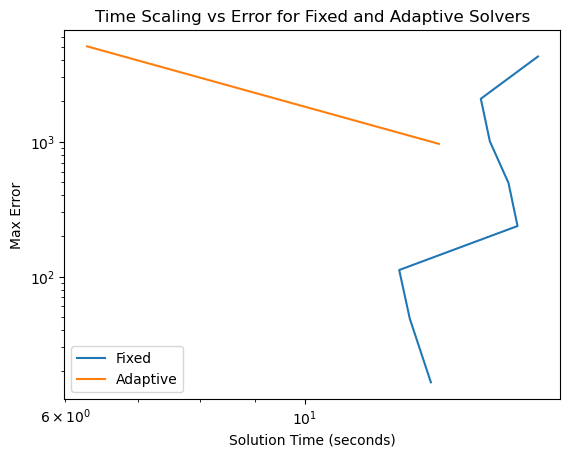

In [18]:
PyPlot.loglog(sol_times[begin+1:end], max_errs[begin+1:end], label="Fixed")
PyPlot.loglog(ad_sol_times[begin+1:end], ad_max_errs[begin+1:end], label="Adaptive")
xlabel("Solution Time (seconds)")
ylabel("Max Error")
legend()
title("Time Scaling vs Error for Fixed and Adaptive Solvers")
PyPlot.display_figs()

In [100]:
curve_fit(LinearFit, log.(reltols)/log(10), log.(ad_max_errs)/log(10))

LinearFit{Float64}((1.1839852660065433, 0.5077252109402588))

In [ ]:
ad_l2_errs = Vector{Float64}(undef, 0)
for i in eachindex(ad_psi_ts[begin:end])
    push!(ad_l2_errs, sqrt(sum(ad_err_ts[i] .^2)))
end
PyPlot.loglog(reltols[begin:end], ad_l2_errs[begin:end])
ylabel("L2 Error")
xlabel("reltol")
title("Scaling of L2 Error with Time Step Size")
PyPlot.display_figs()